In [2]:
# 배당하는 종목과 배당하지 않는 종목의 수익률 비교
# 주가 대비 배당금을 고려하여 투자한 경우도 비교

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

In [3]:
import pandas as pd

data = pd.read_csv("data/재무제표_분석용데이터.csv", encoding = "euc-kr", usecols = ['기업', '연도', '현재_주가', '미래_주가', '배당금'])

In [4]:
import numpy as np

# 미래 배당금, 배당유무 추가
data.rename({"배당금":"현재_배당금"}, axis=1, inplace=True)
data['미래_배당금'] = np.nan
data['미래_배당금'].iloc[:-1] = data['현재_배당금'].iloc[1:]
data.loc[data['연도'] == 2020, '미래_배당금'] = np.nan
data['배당유무'] = (data['현재_배당금'] > 0)
data.dropna(inplace = True)

<AxesSubplot:title={'center':'배당한 기업 비율'}>

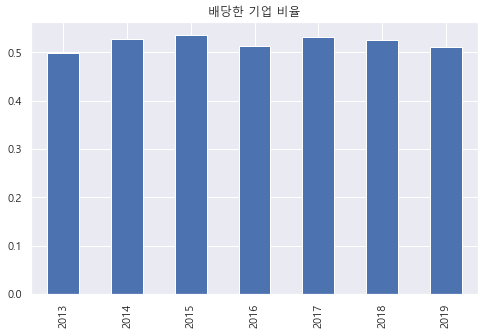

In [6]:
# 배당한 기업의 배당 비율 시각화

num_div = data.groupby('연도')['배당유무'].sum()
num_corp = data['연도'].value_counts()
div_ratio = num_div / num_corp
div_ratio.plot(kind = "bar", figsize = (8, 5), title = "배당한 기업 비율")

# 연도별로 배당한 기업의 차이가 크지 않고, 대부분 50%를 약간 넘음

In [8]:
# 배당 유무에 따른 수익률 비교
# 지난 사업 연도에 배당한 종목은 이번 연도에 매수해서 내년에 매도할 때 얻게 될 수익. 배당금 무시

data['수익률'] = (data['미래_주가'] - data['현재_주가']) / data['현재_주가'] * 100
print(data.groupby(['연도', '배당유무'])['수익률'].describe().round(2))

# 2013, 2014, 2016, 2018, 2019년에 배당하지 않는 기업의 평균 수익률이 높음
# 그러나 2013, 2015, 2017, 2018, 2019년에는 배당하는 종목의 중위수가 더 높음
# 배당 여부에 따라서 수익률에 선형적인 차이가 있다고 말하긴 어려움

             count   mean     std    min    25%    50%     75%      max
연도   배당유무                                                              
2013 False   745.0  39.88  125.11 -87.44  -7.36   7.32   51.18  1737.92
     True    742.0  22.46   49.68 -60.04  -7.52  10.89   38.39   284.30
2014 False   702.0  24.89   72.59 -79.33 -16.69   5.15   42.60   493.47
     True    785.0   6.20   42.92 -71.60 -19.71  -1.26   20.95   429.04
2015 False   686.0   1.87   44.69 -95.51 -24.92  -5.43   18.88   336.51
     True    791.0   4.63   38.69 -71.02 -15.53  -1.74   16.08   310.38
2016 False   839.0  21.84   89.74 -71.19 -19.60   0.00   29.34  1183.78
     True    885.0   7.81   43.82 -75.62 -15.52  -1.17   18.93   451.02
2017 False   806.0  -9.35   43.35 -93.39 -34.28 -17.64    3.09   339.44
     True    918.0  -4.44   34.71 -58.23 -23.09 -10.80    5.16   430.54
2018 False   973.0 -19.41   74.49 -95.50 -49.34 -32.60   -7.28  1152.73
     True   1081.0 -25.58   30.33 -77.86 -43.97 -32.34  -15.24  

In [9]:
# 주가 대비 배당 비율에 따른 수익률 비교

data['배당금/주가'] = data['현재_배당금'] / data['현재_주가']

In [10]:
# 배당하지 않은 기업을 하나로 묶고, 배당한 기업을 4개로 몪음. 1 ~ 4로 갈수록 주가 대비 배당률이 높은 기업
# qcut() : 데이터를 n개의 분위수로 나누어 그루핑

data["배당금/주가 그룹"] = 0

for year in range(2013, 2020):
    idx = data.loc[(data["연도"] == year) & (data["배당유무"])].index
    data.loc[idx, "배당금/주가 그룹"] = pd.qcut(data.loc[idx, "배당금/주가"], 4, labels=[1, 2, 3, 4]).astype(int)

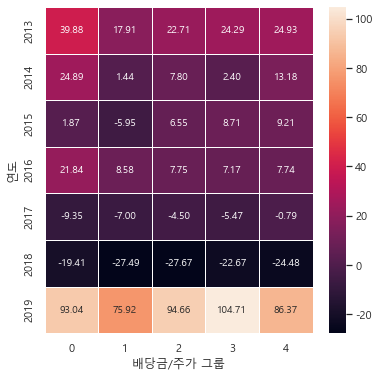

In [11]:
graph_data = data.groupby(['연도', '배당금/주가 그룹'])['수익률'].mean().unstack()
plt.figure(figsize = (6, 6))
sns.heatmap(graph_data, annot = True, fmt = ".2f", linewidth = 1)
plt.show()

# 배당을 하지 않는 그룹 0을 제외하면, 배당률이 높은 3, 4가 1, 2에 비해 평균적으로 높은 수익률을 보임. 물론 절대적이진 않음

## 동일 가중 교체 매매에 따른 수익 비교 (리밸런싱)

In [ ]:
result = []

for year in range(2013, 2020):
    y_data = data.loc[data['연도'] == year]
    record = []
    for group in range(5):
        group_data = y_data.loc[data['배당금/주가 그룹']==group]
        inve_per_stock = 10**8 / len(group_data)
        num_stock_list = inve_per_stock / group_data['현재_주가']
        ror_list = (group_data['미래_주가'] - group_data['현재_주가'] + group_data['미래_배당금']) / group_data['현재_주가'] * 100

        profit = (inve_per_stock * ror_list / 100).sum()
        profit_ratio = profit / 10 ** 8 * 100

        result.append([year, group, profit_ratio])

result = pd.DataFrame(result, columns = ["연도", "그룹", "수익률"])

    count   mean    std    min   25%    50%    75%     max
그룹                                                        
0     7.0  22.13  37.61 -19.28 -3.48  22.11  32.90   93.23
1     7.0   9.77  32.87 -26.89 -5.83   2.12  13.93   76.96
2     7.0  16.65  38.46 -26.46  2.30   8.96  16.49   96.48
3     7.0  19.17  41.69 -20.67  0.36   9.10  18.55  107.92
4     7.0  22.79  35.13 -19.85  8.30  15.17  27.36   92.90


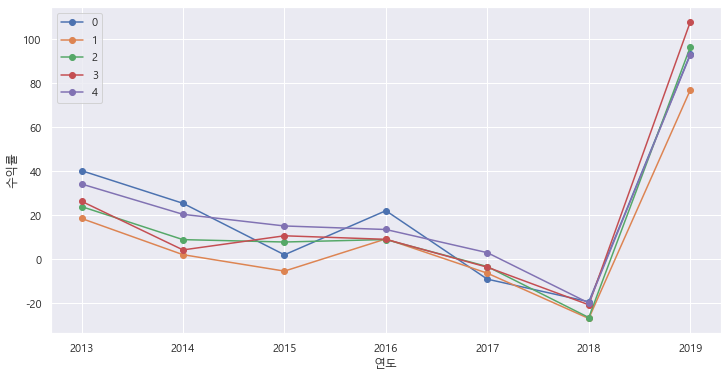

In [14]:
plt.figure(figsize = (12, 6))

for group in range(5):
    graph_data = result.loc[(result['그룹'] == group), '수익률'].values
    plt.plot(graph_data, marker="o", label=group)

plt.xticks(range(7), range(2013, 2020))
plt.legend()
plt.ylabel("수익률")
plt.xlabel("연도")

print(result.groupby('그룹')['수익률'].describe().round(2))

# 배당을 하지 않는 그룹인 0이 평균적으로 높은 수익률을 보이고, 그 다음으로는 가장 높은 주가 대비 배당률을 보이는 4번 그룹이 뒤따름
# 중위수, 3사분위수는 0번 그룹이 가장 높지만, 평균과 1분위수는 4번그룹이 가장 높음. 이는 배당을 높게 하는 그룹이 배당을 하지 않는 그룹에 비해 높은 안정성을 보여줌을 의미